In [1]:
from pathlib import Path
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import Video

import pandas as pd
import numpy as np
import torch

from lagom.envs import make_vec_env
from lagom.utils import pickle_load
from lagom.utils import yaml_load
from lagom.vis import set_ticker
from lagom.vis import read_xy

import os, sys
# solve import error of algos
[sys.path.insert(0, f'{os.getcwd()}/{f}') for f in Path(os.getcwd()).iterdir() if f.is_dir()]


def get_configs(log_folder):
    data = pickle_load(Path(log_folder) / 'configs.pkl')
    configs = pd.DataFrame(data, columns=data[0].keys())
    return configs

In [2]:
def make_video(id_folder, make_env, agent_class, seed, num_iter):
    id_folder = Path(id_folder)
    anim_path = id_folder / str(seed) / 'anim'
    if not anim_path.exists():
        anim_path.mkdir(parents=True)
    config = yaml_load(id_folder / 'config.yml')
    
    env = make_env(config, seed)
    import gym
    env[0] = gym.wrappers.Monitor(env[0], anim_path, force=True)
    
    def standardize(observation, mean, var):
        return (observation - mean)/np.sqrt(var + 1e-8)
    path_obs_moments = id_folder / str(seed) / f'obs_moments_{num_iter}.pth'
    if path_obs_moments.exists():
        obs_mean, obs_var = np.load(path_obs_moments, allow_pickle=True)
    agent = agent_class(config, env, 'cpu')
    agent.load(id_folder / str(seed) / f'agent_{num_iter}.pth')
    agent.eval()
    
    rewards = 0.0
    observation = env.reset()
    with torch.no_grad():
        for t in range(env.spec.max_episode_steps):
            if path_obs_moments.exists():
                observation = standardize(observation, obs_mean, obs_var)
            out = agent.choose_action(observation, mode='eval')
            action = out.get('raw_action', None)
            if action is None:
                action = out.get('action')
            observation, reward, done, info = env.step(action)
            rewards += reward[0]
            if done[0]:
                break
    env.close()
    print(f'Evaluation:\n\tHorizon: {t+1}, Return: {rewards}')
    
    # display the video
    anim_f = list(anim_path.glob('openaigym*000000.mp4'))[0]
    return Video(anim_f)

## Reinforcement Learning
- [VPG](#VPG)
- [PPO](#PPO)
- [DDPG](#DDPG)
- [TD3](#TD3)
- [SAC](#SAC)

## ES
- [CEM](#CEM)
- [CMA-ES](#CMA-ES)
- [OpenAI-ES](#OpenAI-ES)

[Benchmarking](#Benchmarking)

## VPG

In [3]:
log_folder = 'vpg/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.standardize_obs,env.standardize_reward,nn.sizes,agent.lr,agent.use_lr_scheduler,agent.gamma,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,env.id
0,0,10,3,True,True,"[64, 64]",0.001,False,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000,1000,HalfCheetah-v3
1,1,10,3,True,True,"[64, 64]",0.001,False,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000,1000,Hopper-v3
2,2,10,3,True,True,"[64, 64]",0.001,False,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000,1000,Walker2d-v3
3,3,10,3,True,True,"[64, 64]",0.001,False,0.99,0.97,True,0.5,0.01,0.5,True,0.6,1000000,1000,Swimmer-v3


In [4]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.standardize_obs,env.standardize_reward,nn.sizes,agent.lr,agent.use_lr_scheduler,...,agent.gae_lambda,agent.standardize_adv,agent.max_grad_norm,agent.entropy_coef,agent.value_coef,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,env.id
0,1000,-0.767056,3.0,10.0,3.0,True,True,"(64, 64)",0.001,False,...,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0,Swimmer-v3
1,2000,1.666736,3.0,10.0,3.0,True,True,"(64, 64)",0.001,False,...,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0,Swimmer-v3
2,3000,3.928274,3.0,10.0,3.0,True,True,"(64, 64)",0.001,False,...,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0,Swimmer-v3
3,4000,6.023199,3.0,10.0,3.0,True,True,"(64, 64)",0.001,False,...,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0,Swimmer-v3
4,5000,7.957152,3.0,10.0,3.0,True,True,"(64, 64)",0.001,False,...,0.97,True,0.5,0.01,0.5,True,0.6,1000000.0,1000.0,Swimmer-v3


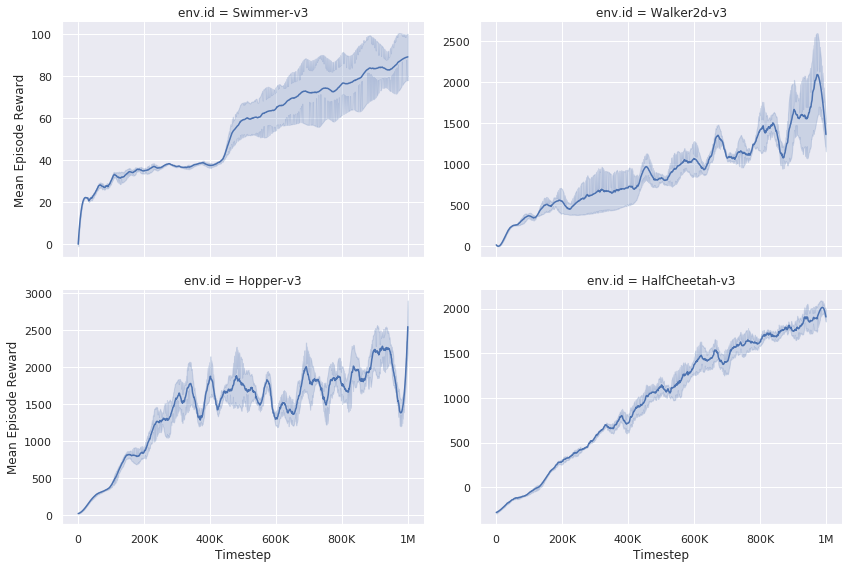

In [5]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [7]:
from vpg.agent import Agent
from vpg.experiment import make_env
ID = 1
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 316, Return: 1001.1723687298686


## PPO

In [8]:
log_folder = 'ppo/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.standardize_obs,env.standardize_reward,nn.sizes,agent.policy_lr,agent.use_lr_scheduler,agent.value_lr,agent.gamma,...,agent.standardize_adv,agent.max_grad_norm,agent.clip_range,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,0,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,HalfCheetah-v3
1,1,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,Hopper-v3
2,2,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,Walker2d-v3
3,3,10,3,True,True,"[64, 64]",0.0003,True,0.001,0.99,...,True,0.5,0.2,True,0.6,1000000,2048,64,10,Swimmer-v3


In [9]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.standardize_obs,env.standardize_reward,nn.sizes,agent.policy_lr,agent.use_lr_scheduler,...,agent.standardize_adv,agent.max_grad_norm,agent.clip_range,env.clip_action,agent.std0,train.timestep,train.timestep_per_iter,train.batch_size,train.num_epochs,env.id
0,2048,9.081023,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
1,4096,11.716919,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
2,6144,14.181911,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
3,8192,16.481594,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3
4,10240,18.621566,3.0,10.0,3.0,True,True,"(64, 64)",0.0003,True,...,True,0.5,0.2,True,0.6,1000000.0,2048.0,64.0,10.0,Swimmer-v3


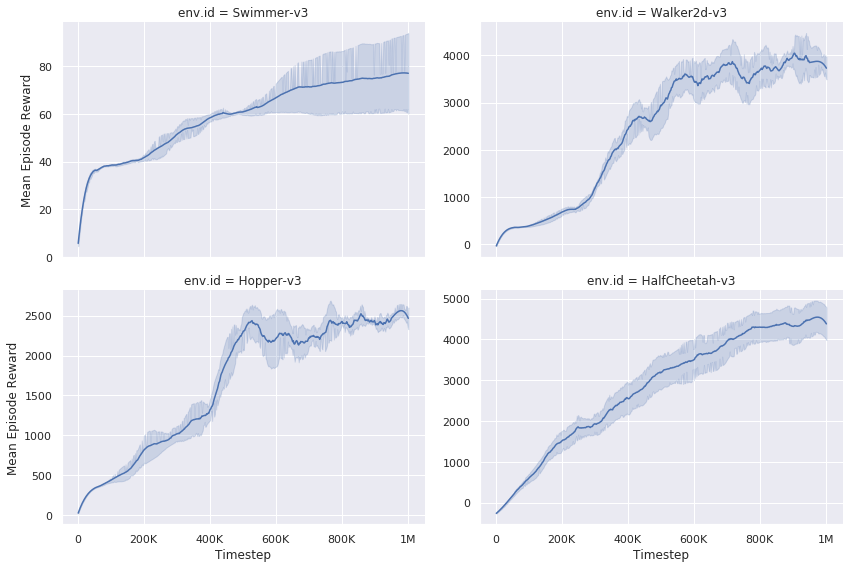

In [10]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [13]:
from ppo.agent import Agent
from ppo.experiment import make_env
ID = 0
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=489)

Evaluation:
	Horizon: 1000, Return: 4663.648824806512


## DDPG

In [11]:
log_folder = 'ddpg/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.action_noise,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,0,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,999999,1000000,10000,100,1000000,5000,10,HalfCheetah-v3
1,1,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,999999,1000000,1000,100,1000000,5000,10,Hopper-v3
2,2,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,999999,1000000,1000,100,1000000,5000,10,Walker2d-v3
3,3,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,999999,1000000,10000,100,1000000,5000,10,Swimmer-v3


In [12]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'eval_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.action_noise,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,5000,8.514640,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
1,10000,8.834707,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
2,15000,9.235331,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
3,20000,9.712230,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
4,25000,10.261118,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,False,0.1,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3


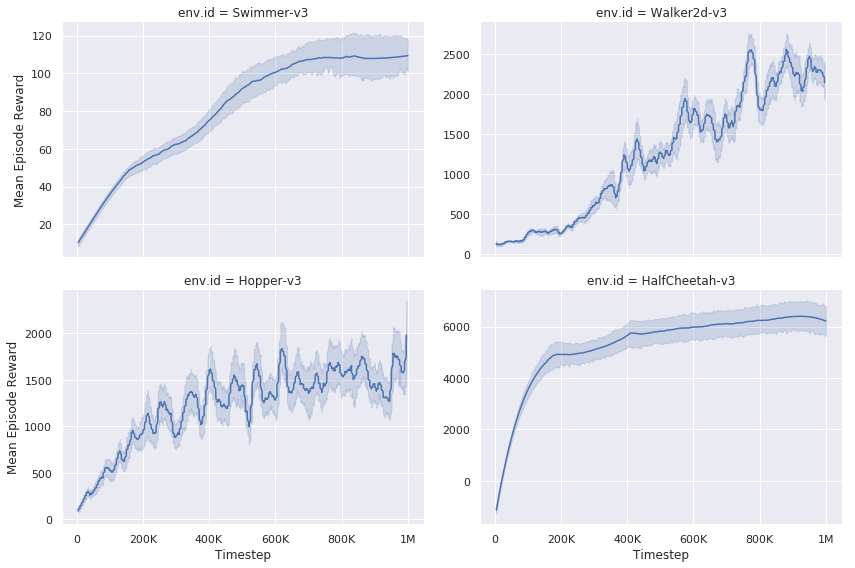

In [13]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [16]:
from ddpg.agent import Agent
from ddpg.experiment import make_env
ID = 3
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=4153361530, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 109.85124658072236


## TD3

In [17]:
log_folder = 'td3/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.action_noise,...,agent.target_noise_clip,agent.policy_delay,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,0,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,10000,100,1000000,5000,10,HalfCheetah-v3
1,1,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,1000,100,1000000,5000,10,Hopper-v3
2,2,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,1000,100,1000000,5000,10,Walker2d-v3
3,3,1000,3,0.99,0.995,0.001,False,0.001,False,0.1,...,0.5,2,999999,1000000,10000,100,1000000,5000,10,Swimmer-v3


In [18]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'eval_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,...,agent.target_noise_clip,agent.policy_delay,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,5000,22.958380,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
1,10000,24.694175,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
2,15000,26.327158,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
3,20000,27.860485,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3
4,25000,29.297316,3.0,1000.0,3.0,0.99,0.995,0.001,False,0.001,...,0.5,2.0,999999.0,1000000.0,10000.0,100.0,1000000.0,5000.0,10.0,Swimmer-v3


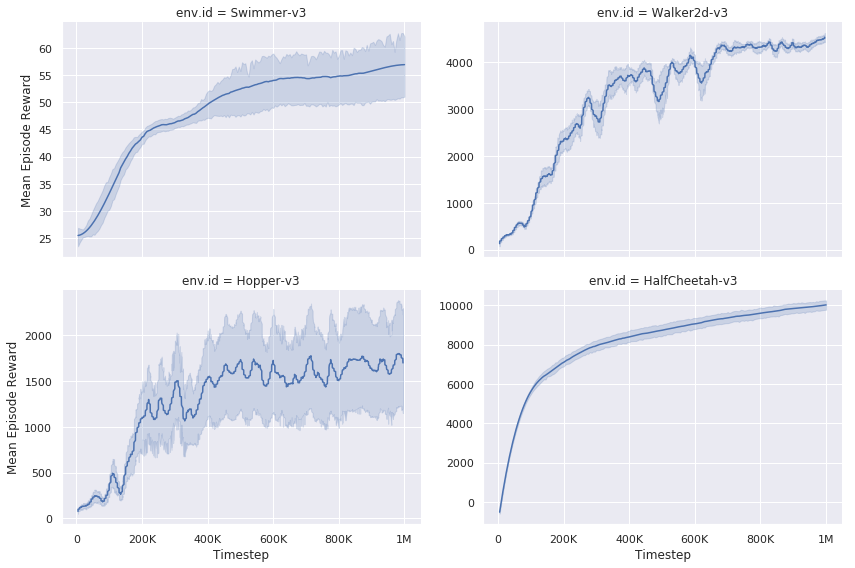

In [19]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [20]:
from td3.agent import Agent
from td3.experiment import make_env
ID = 2
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=849059707, num_iter=1688)

Evaluation:
	Horizon: 1000, Return: 4343.720885515517


## SAC

In [21]:
log_folder = 'sac/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.initial_temperature,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,0,1000,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,10000,256,1000000,5000,10,HalfCheetah-v3
1,1,1000,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,1000,256,1000000,5000,10,Hopper-v3
2,2,1000,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,1000,256,1000000,5000,10,Walker2d-v3
3,3,1000,3,0.99,0.995,0.0003,False,0.0003,False,1.0,999999,1000000,10000,256,1000000,5000,10,Swimmer-v3


In [22]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean
file_name = 'eval_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,agent.gamma,agent.polyak,agent.actor.lr,agent.actor.use_lr_scheduler,agent.critic.lr,agent.critic.use_lr_scheduler,agent.initial_temperature,agent.max_grad_norm,replay.capacity,replay.init_size,replay.batch_size,train.timestep,eval.freq,eval.num_episode,env.id
0,5000,18.492406,3.0,1000.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10000.0,256.0,1000000.0,5000.0,10.0,Swimmer-v3
1,10000,20.940745,3.0,1000.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10000.0,256.0,1000000.0,5000.0,10.0,Swimmer-v3
2,15000,23.239359,3.0,1000.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10000.0,256.0,1000000.0,5000.0,10.0,Swimmer-v3
3,20000,25.393426,3.0,1000.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10000.0,256.0,1000000.0,5000.0,10.0,Swimmer-v3
4,25000,27.408127,3.0,1000.0,3.0,0.99,0.995,0.0003,False,0.0003,False,1.0,999999.0,1000000.0,10000.0,256.0,1000000.0,5000.0,10.0,Swimmer-v3


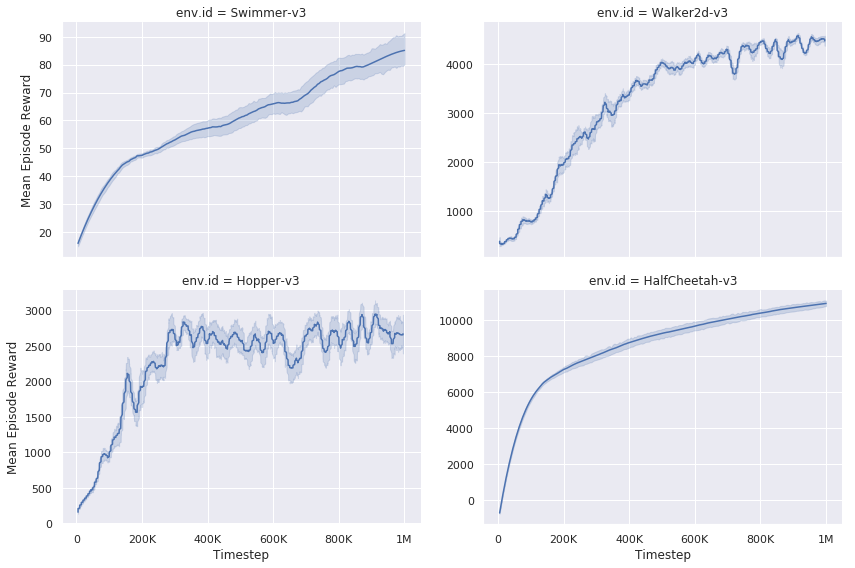

In [23]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [24]:
from sac.agent import Agent
from sac.experiment import make_env
ID = 0
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=4153361530, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 10282.970207630027


## CEM

In [18]:
log_folder = 'cem/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.elite_ratio,train.noise_scheduler_args,env.id
0,0,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",HalfCheetah-v3
1,1,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",Hopper-v3
2,2,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",Walker2d-v3
3,3,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.2,"[0.01, 0.001, 200, 0]",Swimmer-v3


In [19]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.elite_ratio,train.noise_scheduler_args,env.id
0,1,-9.473063,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
1,2,-7.790092,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
2,3,-6.125750,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
3,4,-4.481028,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3
4,5,-2.856913,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.2,"(0.01, 0.001, 200, 0)",Swimmer-v3


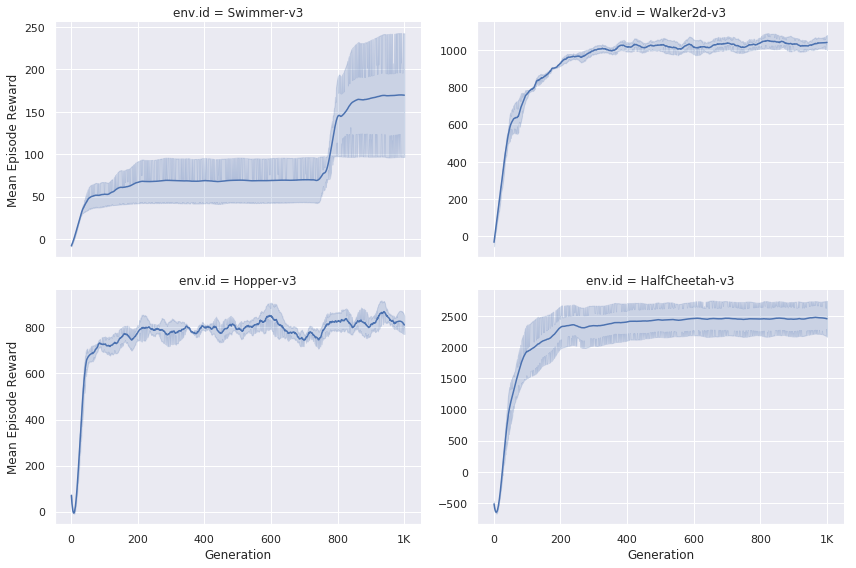

In [20]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [23]:
from cem.agent import Agent
from cem.experiment import make_env
ID = 1
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 1527.042073201088


### CMA-ES

In [9]:
log_folder = 'cmaes/logs/default/'
get_configs(log_folder)

,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,env.id
0,0,False,logs/default,10,50,False,"[64, 64]",True,0.5,1000,64,0.0,1.0,HalfCheetah-v3
1,1,False,logs/default,10,50,False,"[64, 64]",True,0.5,1000,64,0.0,1.0,Hopper-v3
2,2,False,logs/default,10,50,False,"[64, 64]",True,0.5,1000,64,0.0,1.0,Walker2d-v3
3,3,False,logs/default,10,50,False,"[64, 64]",True,0.5,1000,64,0.0,1.0,Swimmer-v3


In [10]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,cuda,log.dir,log.freq,checkpoint.freq,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,env.id
0,1,-4.237852,3.0,False,logs/default,10.0,50.0,False,"(64, 64)",True,0.5,1000.0,64.0,0.0,1.0,Swimmer-v3
1,2,-4.213243,3.0,False,logs/default,10.0,50.0,False,"(64, 64)",True,0.5,1000.0,64.0,0.0,1.0,Swimmer-v3
2,3,-4.131087,3.0,False,logs/default,10.0,50.0,False,"(64, 64)",True,0.5,1000.0,64.0,0.0,1.0,Swimmer-v3
3,4,-3.994174,3.0,False,logs/default,10.0,50.0,False,"(64, 64)",True,0.5,1000.0,64.0,0.0,1.0,Swimmer-v3
4,5,-3.805295,3.0,False,logs/default,10.0,50.0,False,"(64, 64)",True,0.5,1000.0,64.0,0.0,1.0,Swimmer-v3


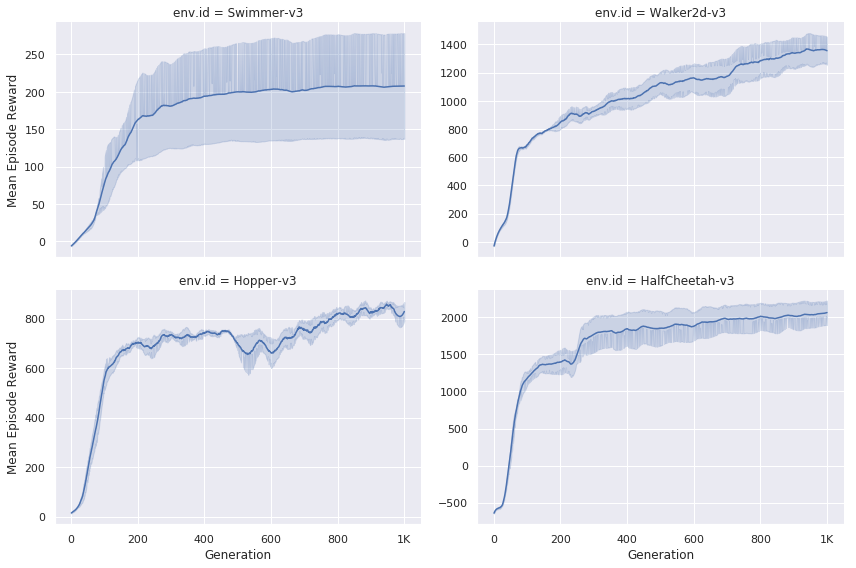

In [11]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [5]:
from cmaes.agent import Agent
from cmaes.experiment import make_env
ID = 1
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 1557.79705245007


### OpenAI-ES

In [12]:
log_folder = 'openaies/logs/default/'
get_configs(log_folder)

,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.lr,train.lr_decay,train.min_lr,train.sigma_scheduler_args,train.antithetic,train.rank_transform,env.id
0,0,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,HalfCheetah-v3
1,1,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,Hopper-v3
2,2,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,Walker2d-v3
3,3,10,3,False,"[64, 64]",True,0.6,1000,64,0.0,1.0,0.01,1.0,0.000001,"[1.0, 0.01, 450, 0]",False,True,Swimmer-v3


In [13]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean
file_name = 'train_logs.pkl'
data = read_xy(log_folder, file_name, get_x, get_y, smooth_out=True)
data.head()

,x,y,ID,log.freq,checkpoint.num,env.standardize_obs,nn.sizes,env.clip_action,agent.std0,train.generations,train.popsize,train.mu0,train.std0,train.lr,train.lr_decay,train.min_lr,train.sigma_scheduler_args,train.antithetic,train.rank_transform,env.id
0,1,-1.894021,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
1,2,-2.299505,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
2,3,-2.671625,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
3,4,-3.011631,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3
4,5,-3.320772,3.0,10.0,3.0,False,"(64, 64)",True,0.6,1000.0,64.0,0.0,1.0,0.01,1.0,0.000001,"(1.0, 0.01, 450, 0)",False,True,Swimmer-v3


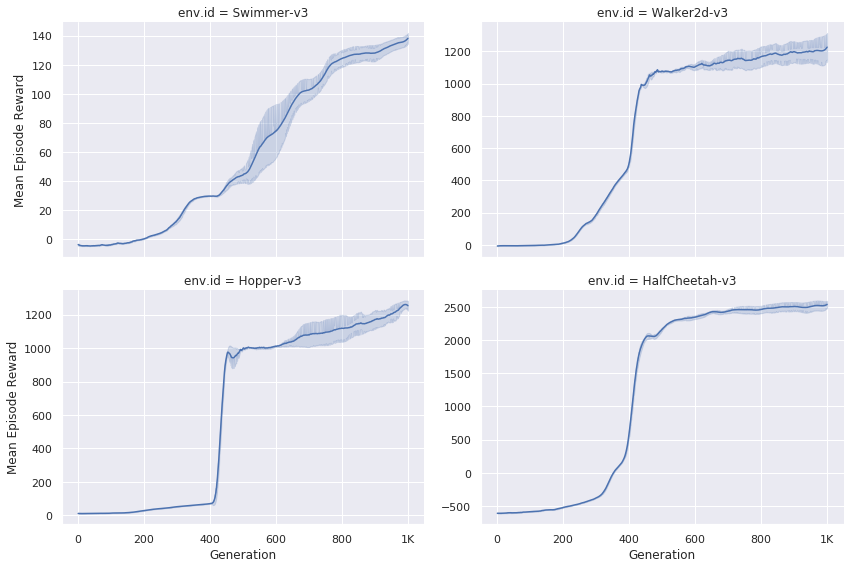

In [14]:
err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue=None,
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'{log_folder}/result.png')

In [17]:
from openaies.agent import Agent
from openaies.experiment import make_env
ID = 3
make_video(f'{log_folder}/{ID}', make_env, Agent, seed=1500925526, num_iter=1000)

Evaluation:
	Horizon: 1000, Return: 154.54793664885457


## Benchmarking

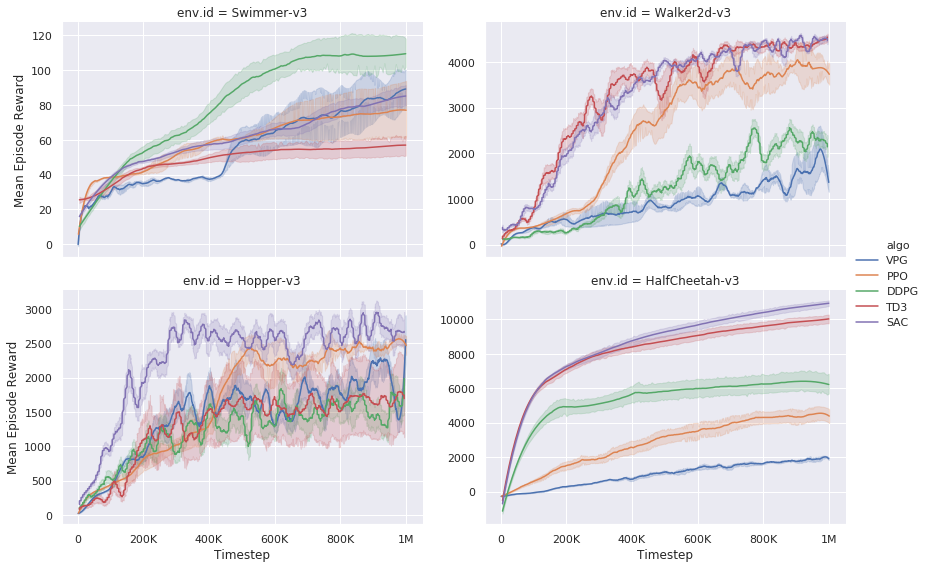

In [25]:
get_x = lambda log: log['accumulated_trained_timesteps'][0]
get_y = lambda log: log['online_return'][0].mean

data = []
d = read_xy('vpg/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'VPG'
data.append(d)
d = read_xy('ppo/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'PPO'
data.append(d)
d = read_xy('ddpg/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'DDPG'
data.append(d)
d = read_xy('td3/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'TD3'
data.append(d)
d = read_xy('sac/logs/default', 'eval_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'SAC'
data.append(d)
data = pd.concat(data, ignore_index=True, sort=False)

err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue='algo',
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Timestep')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'benchmark_rl.png')

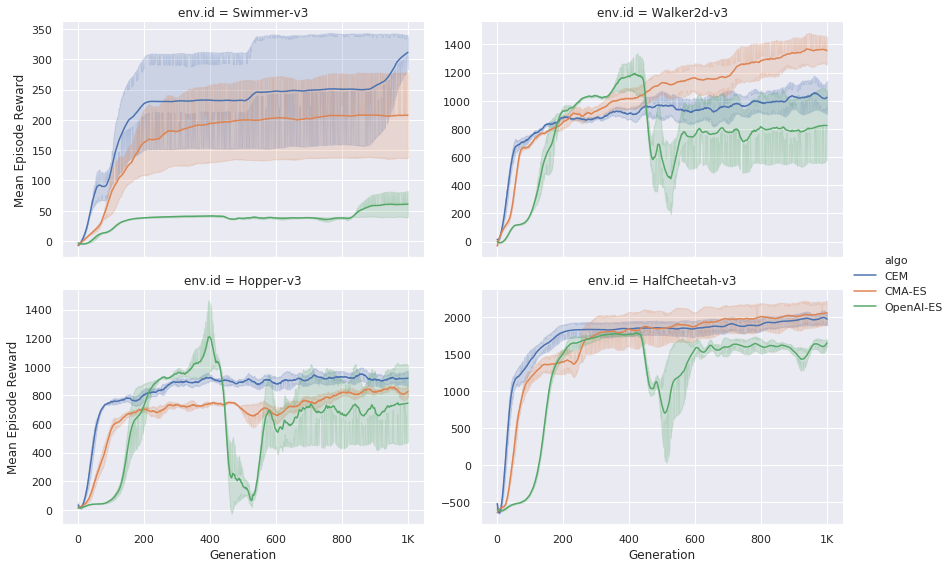

In [16]:
get_x = lambda log: log['generation'][0]
get_y = lambda log: log['Returns'][0].mean

data = []
d = read_xy('cem/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'CEM'
data.append(d)
d = read_xy('cmaes/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'CMA-ES'
data.append(d)
d = read_xy('openaies/logs/default', 'train_logs.pkl', get_x, get_y, smooth_out=True)
d['algo'] = 'OpenAI-ES'
data.append(d)
data = pd.concat(data, ignore_index=True, sort=False)

err_kws = {'ci': 50, 'err_kws': {'alpha': 0.2}}
g = sns.relplot(data=data, 
                x='x', 
                y='y', 
                hue='algo',
                kind='line',
                **err_kws, 
                col='env.id', 
                col_wrap=2, 
                height=4,
                aspect=1.5,  # (4, 6) figsize
                facet_kws=dict(sharex=True, sharey=False))
[set_ticker(ax, axis='x', num=6, KM_format=True, integer=True) for ax in g.axes.flatten()]
g.set_xlabels('Generation')
g.set_ylabels('Mean Episode Reward')
g.savefig(f'benchmark_es.png')